Saturation curves for SM-omics and ST<br>

Input files are generated by counting number of unique molecules and number of annotated reads per annotated region after adjusting for sequencing depth, in downsampled fastq files (proportions 0.001, 0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1) processed using ST-pipeline.<br>


In [1]:
%matplotlib inline
import os
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import glob
import warnings
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
warnings.filterwarnings('ignore')

In [2]:
def condition(row):
    """ Takes row in pandas df as input and returns type of condition
    """
    # The samples are run in triplicate based on condition
    condition = ['sm-omics', 'ST']

    if row['Name'] in ['10015CN84_D2', '10015CN84_C2', '10015CN60_E2']:
        return condition[0]
    
    elif row['Name'] in ['10005CN48_C1','10005CN48_D1','10005CN48_E1']:
        return condition[1]
    

In [3]:
# Load input files
path = '../../smomics_data'

stats_list = []

samples_list = ['10005CN48_C1', '10005CN48_D1', '10005CN48_E1', '10015CN84_D2', '10015CN84_C2', '10015CN60_E2']
    
spots_under_tissue = {'10005CN48_C1':258,
              '10005CN48_D1':252,
               '10005CN48_E1':203,
              '10015CN84_D2': 201,
              '10015CN84_C2': 241,
            '10015CN60_E2':235}

prop_list = [0.001, 0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1]

for filename in samples_list:
    
    cond_file = pd.read_csv(os.path.join(path, filename + '_genes_after_seq_depth_in_spots_under_outside_tissue.txt'), sep = '\t')
    print(cond_file)
    
    if numpy.unique(cond_file['Name']) == '10005CN60_E2':
        cond_file['Name'] = '10015CN60_E2'
    cond_file['Condition'] = cond_file.apply(lambda row: condition(row), axis = 1)
    
    cond_file.sort_values(by='Num reads', inplace=True)
    cond_file['Prop_annot_reads'] = prop_list
    
    cond_file['norm uniq gen inside'] = cond_file['Genes inside']
    cond_file['norm uniq gen outside'] = cond_file['Genes outside']

    stats_list.append(cond_file)

# Concat all files
cond_merge = pd.concat(stats_list)
    

           Name  Genes inside  Genes outside  Annot reads  Num reads
0  10005CN48_C1   1605.209386     668.109589      6071267   26844551
1  10005CN48_C1   1438.158845     591.891781      4913472   13980500
2  10005CN48_C1    125.924188      46.820548       403310    1148609
3  10005CN48_C1    371.841155     145.068493       956640    2724456
4  10005CN48_C1    598.425993     238.431507      1522764    4332462
5  10005CN48_C1   1605.209386     668.109589      6071267   20412525
6  10005CN48_C1   1605.209386     668.109589      6071267   33276576
7  10005CN48_C1    172.119134      65.517808       505165    1438051
8  10005CN48_C1    958.790614     387.890411      2652120    7548475
           Name  Genes inside  Genes outside  Annot reads  Num reads
0  10005CN48_D1   1553.762963     807.383989      6621929   33276576
1  10005CN48_D1    516.229630     253.690638      1397917    4332462
2  10005CN48_D1     99.044444      49.516961       370691    1148609
3  10005CN48_D1    320.429630     

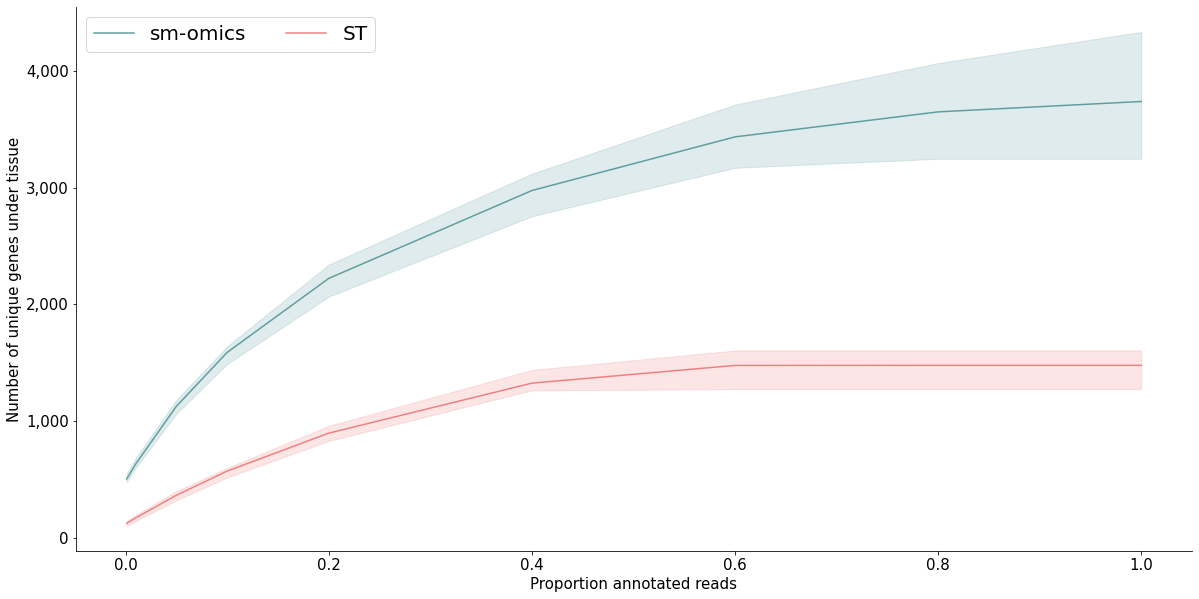

In [4]:
#Plot 
fig = plt.figure(figsize=(20, 10))
x="Prop_annot_reads"
y="norm uniq gen inside"
#y="Genes"
hue='Condition'

################ LINE PLOT

ax = sns.lineplot(x=x, y=y, data=cond_merge,hue=hue, 
                  palette =['cadetblue', 'lightcoral'], hue_order = ['sm-omics', 'ST'],ci=95)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('k')
ax.spines['left'].set_color('k')

# X and y label size
ax.set_xlabel("Proportion annotated reads", fontsize=15)
ax.set_ylabel("Number of unique genes under tissue", fontsize=15)

# Set ticks size
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)

# change background color
back_c = 'white'
ax.set_facecolor(back_c)
ax.grid(False)

# Thousand seprator on y axis
ax.get_yaxis().set_major_formatter(
matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# LEGEND
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=['sm-omics', 'ST'],loc='upper left', ncol=2, fontsize=20)


fig.set_size_inches(20, 10)
# plt.savefig("../../figures/saturation_sm_st_total_genes_inside.pdf", transparent=True, bbox_inches = 'tight',
#      pad_inches = 0, dpi=1200)
plt.show()

In [5]:
cond_merge['Prop_annot_reads'] = 100*cond_merge['Prop_annot_reads']

In [6]:
#cond_merge.to_csv('../../smomics_data/sm_st_unique_genes_under_outside_tissue.csv')

In [7]:
cond_merge


,Name,Genes inside,Genes outside,Annot reads,Num reads,Condition,Prop_annot_reads,norm uniq gen inside,norm uniq gen outside
2,10005CN48_C1,125.924188,46.820548,403310,1148609,ST,0.1,125.924188,46.820548
7,10005CN48_C1,172.119134,65.517808,505165,1438051,ST,1.0,172.119134,65.517808
3,10005CN48_C1,371.841155,145.068493,956640,2724456,ST,5.0,371.841155,145.068493
4,10005CN48_C1,598.425993,238.431507,1522764,4332462,ST,10.0,598.425993,238.431507
8,10005CN48_C1,958.790614,387.890411,2652120,7548475,ST,20.0,958.790614,387.890411
1,10005CN48_C1,1438.158845,591.891781,4913472,13980500,ST,40.0,1438.158845,591.891781
5,10005CN48_C1,1605.209386,668.109589,6071267,20412525,ST,60.0,1605.209386,668.109589
0,10005CN48_C1,1605.209386,668.109589,6071267,26844551,ST,80.0,1605.209386,668.109589
6,10005CN48_C1,1605.209386,668.109589,6071267,33276576,ST,100.0,1605.209386,668.109589
2,10005CN48_D1,99.044444,49.516961,370691,1148609,ST,0.1,99.044444,49.516961
